In [1]:
import numpy as np
import pandas as pd
import os
from numpy import sqrt, power
from scipy import pi, exp, log, optimize
from scipy.integrate import quad
from scipy.stats import norm
import time
from sklearn import tree
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

In [2]:
def bsprice(S, K, T, sigma, isCall=True):
    d1=(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    if isCall:
        return S*norm.cdf(d1,0,1)-K*norm.cdf(d2,0,1)
    else:
        return K*norm.cdf(-d2,0,1)-S*norm.cdf(-d1,0,1)

def bsdelta(S, K, T, sigma, isCall=True):
    d1=(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if isCall:
        return norm.cdf(d1,0,1)
    else:
        return -norm.cdf(-d1,0,1)

def bsgamma(S, K, T, sigma):
    d1=(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    return norm.pdf(d1,0,1)/(S*sigma*T**0.5)


def implied_vol(target_value, S, K, T, isCall=True):
    return optimize.brentq(lambda sig: bsprice(S,K,T,sig,isCall)-target_value,0.01,0.5)

In [3]:
def heston_phi(z, tau, v, vbar, lamb, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ):
    a0=lamb-rho*eta*z*1j
    gamma=power(eta**2*(z**2+z*1j)+a0*a0, 0.5)
    G=(a0-gamma)/(a0+gamma)
    a1=v/eta/eta*((1-exp(-gamma*tau))/(1-G*exp(-gamma*tau)))*(a0-gamma)
    a2=lamb*vbar/eta/eta*(tau*(a0-gamma)-2*log((1-G*exp(-gamma*tau))/(1-G))) #c*vbar
    if lambdaJ == 0:
        return exp(a1+a2)
    I=1.0
    if vJJ != 0:
        integrand=lambda t: np.exp(vJJ/eta/eta*((1-exp(-gamma*t))/(1-G*exp(-gamma*t)))*(a0-gamma))
        I=(1.0/tau)*(quad(lambda t: integrand(t).real, 0, tau, limit=500)[0]+1j*quad(lambda t: integrand(t).imag, 0, tau, limit=500)[0])
    psi=tau*lambdaJ*(exp(1j*z*alphaJ-0.5*z**2*deltaJ**2)*I-1-1j*z*(exp(alphaJ+0.5*deltaJ**2)-1))
    return exp(a1+a2+psi)
    

def heston_phi_call(k, tau, v, vbar, lambd, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ, AL):
    integrand=lambda z: (exp(-z*k*1j)*heston_phi(z-(AL+1)*1j, tau, v, vbar, lambd, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ)/(AL**2+AL-z**2+1j*(2*AL+1)*z)).real
    return quad(integrand, 0, 500, limit=250)[0]

def heston_call(S,K,tau,v,vbar,lambd,eta,rho, lambdaJ, alphaJ, deltaJ,vJJ,r=0,divYield=0):
    dampFac=0.5
    k=log(K/S)-r*tau+divYield*tau
    integral=heston_phi_call(k, tau, v, vbar, lambd, eta,rho, lambdaJ, alphaJ, deltaJ,vJJ,dampFac)
    return exp(-divYield*tau)*S*exp(-dampFac*k)*integral/pi
    
def heston_phi_put(k, tau, v, vbar, lambd, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ, AL):
    integrand=lambda z: (exp(-z*k*1j)*heston_phi(z-(-AL+1)*1j, tau, v, vbar, lambd, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ)/(AL**2-AL-z**2+1j*(-2*AL+1)*z)).real
    return quad(integrand, 0, 500, limit=250)[0]

def heston_put(S,K,tau,v,vbar,lambd,eta,rho, lambdaJ, alphaJ, deltaJ, vJJ,r=0,divYield=0):
    dampFac=3
    k=log(K/S)-r*tau+divYield*tau
    integral=heston_phi_put(k, tau, v, vbar, lambd, eta,rho, lambdaJ, alphaJ, deltaJ, vJJ,dampFac)
    return exp(-divYield*tau)*S*exp(dampFac*k)*integral/pi   

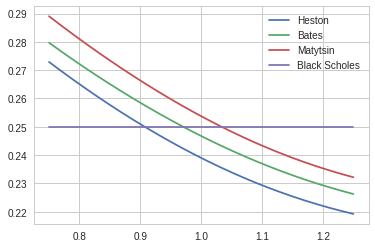

In [4]:
V0, Vbar, kappa, alpha, rho, lambdaJ, alphaJ, deltaJ, vJJ = 0.25**2, 0.25**2, 3, 0.5, -0.5, 0.2, -0.1, 0.1, 0.1
x=np.linspace(0.75,1.25,26)
ivh=[]
ivb=[]
ivm=[]
T=1
for s in x:
    if s<1:
        ph=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,0,alphaJ,deltaJ,0)
        pb=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,0)
        pm=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ)
    else:
        ph=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,0,alphaJ,deltaJ,0)
        pb=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,0)
        pm=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ)
    ivh.append(implied_vol(ph, 1, s, T, isCall=s>=1))
    ivb.append(implied_vol(pb, 1, s, T, isCall=s>=1))
    ivm.append(implied_vol(pm, 1, s, T, isCall=s>=1))

plt.plot(x, ivh, label="Heston")
plt.plot(x, ivb, label="Bates")
plt.plot(x, ivm, label="Matytsin")
plt.plot(x, 0.25*np.ones(26), label="Black Scholes")
plt.legend()

plt.savefig('hbmbs_ivs.pdf')

In [ ]:
def generatePath(params):
    V0, Vbar, kappa, alpha, rho = params
    
    BSC=np.zeros((n_sims, n_t+1))
    HC=np.zeros((n_sims, n_t+1))
    BC=np.zeros((n_sims, n_t+1))
    MC=np.zeros((n_sims, n_t+1))
    HV=V0*np.ones((n_sims, n_t+1))
    MV=V0*np.ones((n_sims, n_t+1))
    for j in range(n_t):
        W1=np.random.randn(n_sims)
        W2=rho*W1+(1-rho**2)**0.5*np.random.randn(n_sims)
        W=np.random.randn(n_sims)
        U=np.random.uniform(size=(n_sims))

        BSC[:,1+j]=BSC[:,j]+np.sqrt(V0)*W1*sqrtDt-0.5*V0*dt
        HC[:,1+j]=HC[:,j]+np.sqrt(HV[:,j])*W1*sqrtDt-0.5*HV[:,j]*dt
        HV[:,1+j]=np.maximum(0.0001**2, HV[:,j]+kappa*(Vbar-HV[:,j])*dt+alpha*np.sqrt(HV[:,j])*W2*sqrtDt)
        BC[:,1+j]=BC[:,j]+np.sqrt(HV[:,j])*W1*sqrtDt-0.5*HV[:,j]*dt-\
                    lambdaJ*(exp(alphaJ+0.5*deltaJ**2)-1)*dt+np.where(U<dt*lambdaJ, alphaJ+deltaJ*W, 0)
        MC[:,1+j]=MC[:,j]+np.sqrt(MV[:,j])*W1*sqrtDt-0.5*MV[:,j]*dt-\
                    lambdaJ*(exp(alphaJ+0.5*deltaJ**2)-1)*dt+np.where(U<dt*lambdaJ, alphaJ+deltaJ*W, 0)
        MV[:,1+j]=np.maximum(0.0001**2, MV[:,j]+kappa*(Vbar-MV[:,j])*dt+alpha*np.sqrt(MV[:,j])*W2*sqrtDt)+\
                    np.where(U<dt*lambdaJ, vJJ, 0)
    
    return np.exp(BSC), np.exp(HC), np.exp(BC), np.exp(MC)

In [ ]:
V0, Vbar, kappa, alpha, rho = 0.25**2, 0.25**2, 3, 0.5, -0.5
lambdaJ, alphaJ, deltaJ=0.2,-0.1,0.1
vJJ=0.1

win_vt=20
sigma_vt=0.1

n_sims=100000
n_t=365+win_vt
n_d=n_t
dt=1.0/365
sqrtDt=dt**0.5

names=["BS","H","B","M"]

np.random.seed(3)
paths=generatePath((V0, Vbar, kappa, alpha, rho)) #BS, H, B, M

# Balanced vol target

In [ ]:
def computeVTBalanced(S, balanced=False, me=None):
    n_sims=S.shape[0]
    ret = S[:,1:]/S[:,:-1]-1
    logRetSqr=np.power(np.log(1+ret),2)
  
    sigma_real = np.zeros((n_sims, n_d+1))
    sigma_used = np.zeros((n_sims, n_d+1))
    exp_used = np.zeros((n_sims, n_d+1))
    vt=np.ones((n_sims, n_d+1))
    int_var=0
    for j in range(win_vt, n_d+1):
        if j > win_vt+1:
            vt[:,j]=vt[:,j-1]*(1+np.multiply(lastExp, ret[:,j-1]))
            if balanced:
                int_var+=np.square(np.log(1+np.multiply(lastExp, ret[:,j-1])))
            
        if win_vt < j and j < n_d:
            sigma_used[:,j]=sigma_vt
            if balanced:
                sigma_used[:,j]=np.maximum(0.0001, (sigma_vt**2-int_var)/min(1, (n_d -j)/365))**0.5
            lastExp=sigma_used[:,j]/sigma_real[:,j-1]
            if me is not None:
                lastExp=np.minimum(lastExp, me)
            exp_used[:,j]=lastExp
                
        sigma_real[:,j]=np.sqrt(365/win_vt*np.sum(logRetSqr[:,j-win_vt:j], axis=1))

    return vt, sigma_real, sigma_used, exp_used

In [ ]:
vt=[]
vtb=[]
sub=[]
e=[]
eb=[]
for p in paths[1:2]:
    tvt, _, _, te = computeVTBalanced(p,False,1.5)
    vt.append(tvt)
    e.append(te)
    tvt, _, tsu, te = computeVTBalanced(p,True,1.5)
    vtb.append(tvt)
    sub.append(tsu)
    eb.append(te)

In [ ]:
qv=[]
qvb=[]
for i in range(4):
    qv.append(np.power(np.log(vt[i][:,win_vt+1:]/vt[i][:,win_vt:-1]),2).sum(axis=1)**0.5)
    qvb.append(np.power(np.log(vtb[i][:,win_vt+1:]/vtb[i][:,win_vt:-1]),2).sum(axis=1)**0.5)

In [ ]:
df=pd.DataFrame()
for i in range(4):
    df[names[i]]=qv[i]
    df[names[i]+"balanced"]=qvb[i]
df.describe()

In [ ]:
d=np.zeros((4,2))
for i in range(4):
    p=np.mean(np.maximum(vt[i][:,-1]-1,0))
    d[i,0]=implied_vol(p,1,1,1)
    p=np.mean(np.maximum(vtb[i][:,-1]-1,0))
    d[i,1]=implied_vol(p,1,1,1)
df=pd.DataFrame(d,index=names,columns=["normal","balanced"])
df

In [ ]:
j=3
fig, axs = plt.subplots(4)
fig.set_size_inches(10,10)
for i in range(4):
    axs[i].plot(np.array([(k-20)/365 for k in range(20,386)]),vt[i][j,20:],label=names[i]+" normal")
    axs[i].plot(np.array([(k-20)/365 for k in range(20,386)]),vtb[i][j,20:],label=names[i]+" balanced")
    axs[i].set_title(names[i])
    axs[i].legend()

In [ ]:
fig, axs = plt.subplots(4)
fig.set_size_inches(10,10)
for i in range(4):
    axs[i].plot(np.array([(k-20)/365 for k in range(20,386)]),e[i][j,20:],label=names[i]+" normal exposure")
    axs[i].plot(np.array([(k-20)/365 for k in range(20,386)]),eb[i][j,20:],label=names[i]+" balanced exposure")
    axs[i].set_title(names[i])
    axs[i].legend()

In [ ]:
plt.xlim(0.09,0.15)
for i in range(2):
    sns.kdeplot(qv[i],label=names[i])
plt.title("density quadratic variation")

In [ ]:
plt.xlim(0.09,0.11)
for i in range(2):
    sns.kdeplot(qvb[i],label=names[i],bw=0.0001)
plt.title("density quadratic variation balanced")

In [ ]:
#we have sold a call
def delta_hedge(paths, sigma):
    num_p, num_t=paths.shape
    #we receive the premium
    cash=bsprice(1, 1, 1, sigma)*np.ones(num_p)
    #do delta hedging
    for i in range(num_t-1):
        t=(num_t-1-i)*dt
        d=bsdelta(paths[:,i], 1, t, sigma)
        cash=cash+d*(paths[:,i+1]-paths[:,i])
    #and pay the payoff of the call
    cash=cash-np.maximum(paths[:,-1]-1,0)
    return cash,np.maximum(paths[:,-1]-1,0)
    
print("bs")
hedge_cost, po=delta_hedge(paths[0][:,:-20], 0.25)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))
print("bs vt")
hedge_cost, po=delta_hedge(vt[0][:,:-20], 0.1025)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))
print("h vt")
hedge_cost, po=delta_hedge(vt[1][:,20:], 0.1075)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))
print("h vt balanced")
hedge_cost, po=delta_hedge(vtb[1][:,20:], 0.100)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))

# Gamma weighted vol target

In [ ]:
def computeVTGamma(S, K=1, b=(0.05,0.05), me=None):
    n_sims=S.shape[0]
    ret = S[:,1:]/S[:,:-1]-1
    logRetSqr=np.power(np.log(1+ret),2)
    
    sigma_real = np.zeros((n_sims, n_d+1))
    sigma_used = np.zeros((n_sims, n_d+1))
    exp_used = np.zeros((n_sims, n_d+1))
    vt=np.ones((n_sims, n_d+1))
    int_var=0
    for j in range(win_vt, n_d+1):
        if j > win_vt+1:
            vt[:,j]=vt[:,j-1]*(1+np.multiply(lastExp, ret[:,j-1]))
            
        if win_vt<j and j<n_d:
            if j > win_vt+1:
                gamma=bsgamma(vt[:,j-1],K,(n_d - (j-1))/365,sigma_vt)
                int_var+=0.5*gamma*np.square(vt[:,j-1])*(sigma_vt**2/365.0-np.square(np.multiply(lastExp, ret[:,j-1])))

            fin_gam=0
            for k in range(j,n_d):
                fin_gam=fin_gam+bsgamma(vt[:,j],K,(n_d-k)/365,sigma_vt)
            fin_gam = 0.5*fin_gam*np.square(vt[:,j])
            fin_gam = np.where(np.abs(fin_gam)<0.0001,0.0001,fin_gam)
            
            sigma_used[:,j]= np.maximum(0.0001, sigma_vt**2+365*int_var/fin_gam)**0.5
            sigma_used[:,j]= np.maximum(sigma_vt-b[0], np.minimum(sigma_vt+b[1], sigma_used[:,j]))
            lastExp=sigma_used[:,j]/sigma_real[:,j-1]
            if me is not None:
                lastExp=np.minimum(lastExp, me)
            exp_used[:,j]=lastExp

        sigma_real[:,j]=np.sqrt(365/win_vt*np.sum(logRetSqr[:,j-win_vt:j], axis=1))

    return vt, sigma_real, sigma_used, exp_used

In [ ]:
vtg=[]
sug=[]
eg=[]
for p in paths:
    tvt, _, tsu, te = computeVTGamma(p,1,(0.05,0.05),1.5)
    vtg.append(tvt)
    sug.append(tsu)
    eg.append(te)

In [ ]:
j=6
fig, axs = plt.subplots(4)
fig.set_size_inches(10,10)
for i in range(4):
    axs[i].plot(np.array([(k-20)/365 for k in range(20,386)]),vt[i][j,20:],label=names[i]+" normal")
    axs[i].plot(np.array([(k-20)/365 for k in range(20,386)]),vtb[i][j,20:],label=names[i]+" balanced")
    axs[i].plot(np.array([(k-20)/365 for k in range(20,386)]),vtg[i][j,20:],label=names[i]+" gamma")
    axs[i].set_title(names[i])
    axs[i].legend()

In [ ]:
def delta_hedge(paths, sigma):
    #we have sold a call
    num_p, num_t=paths.shape
    #we receive the premium
    cash=bsprice(1, 1, 1, sigma)*np.ones(num_p)
    #do delta hedging
    for i in range(num_t-1):
        t=(num_t-1-i)*dt
        d=bsdelta(paths[:,i], 1, t, sigma)
        cash=cash+d*(paths[:,i+1]-paths[:,i])
    #and pay the payoff of the call
    cash=cash-np.maximum(paths[:,-1]-1,0)
    return cash,np.maximum(paths[:,-1]-1,0)
    
print("BS")
hedge_cost, po=delta_hedge(paths[0][:,:-20], 0.25)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))
print("vt H")
hedge_cost, po=delta_hedge(vt[1][:,20:], 0.1075)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))
print("vt H balanced")
hedge_cost, po=delta_hedge(vtb[1][:,20:], 0.100)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))
print("vt H gamma")
hedge_cost, po=delta_hedge(vtg[1][:,20:], 0.101)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))

# Adaptive vol target

In [ ]:
def computeVTAdap(S, cps=None, b=None, me=None):
    n_sims=S.shape[0]
    ret = S[:,1:]/S[:,:-1]-1
    logRetSqr=np.power(np.log(1+ret),2)
    
    sigma_real = np.zeros((n_sims, n_d+1))
    sigma_used = np.zeros((n_sims, n_d+1))
    vt=np.ones((n_sims, n_d+1))
    balanced = cps is not None
    cps_i=0
    int_var=0
    for j in range(win_vt, n_d+1):
        if j > win_vt+1:
            vt[:,j]=vt[:,j-1]*(1+np.multiply(lastExp, ret[:,j-1]))
            if balanced:
                if j==cps[cps_i+1]:
                    int_var=0
                    cps_i+=1
                else:
                    int_var+=np.square(np.log(1+np.multiply(lastExp, ret[:,j-1])))
            
        if win_vt < j and j < n_d:
            sigma_used[:,j]=sigma_vt
            if balanced:
                sigma_used[:,j] = np.maximum(0.0001, (sigma_vt**2*(cps[cps_i+1]-cps[cps_i])/365-int_var)/((cps[cps_i+1]-j)/365))**0.5
                if b is not None:
                    sigma_used[:,j]=np.minimum(np.maximum(sigma_used[:,j],sigma_vt-b[0]),sigma_vt+b[1])
            lastExp=sigma_used[:,j]/sigma_real[:,j-1]
            if me is not None:
                lastExp=np.minimum(lastExp, me)
                
        sigma_real[:,j]=np.sqrt(365/win_vt*np.sum(logRetSqr[:,j-win_vt:j], axis=1))

    return vt, sigma_real, sigma_used

In [ ]:
def computeVTBalanced(S, balanced=False, me=None):
    n_sims=S.shape[0]
    ret = S[:,1:]/S[:,:-1]-1
    logRetSqr=np.power(np.log(1+ret),2)
  
    sigma_real = np.zeros((n_sims, n_d+1))
    sigma_used = np.zeros((n_sims, n_d+1))
    exp_used = np.zeros((n_sims, n_d+1))
    vt=np.ones((n_sims, n_d+1))
    int_var=0
    for j in range(win_vt, n_d+1):
        if j > win_vt+1:
            vt[:,j]=vt[:,j-1]*(1+np.multiply(lastExp, ret[:,j-1]))
            if balanced:
                int_var+=np.square(np.log(1+np.multiply(lastExp, ret[:,j-1])))
            
        if win_vt < j and j < n_d:
            sigma_used[:,j]=sigma_vt
            if balanced:
                sigma_used[:,j]=np.maximum(0.0001, (sigma_vt**2-int_var)/min(1, (n_d -j)/365))**0.5
            lastExp=sigma_used[:,j]/sigma_real[:,j-1]
            if me is not None:
                lastExp=np.minimum(lastExp, me)
            exp_used[:,j]=lastExp
                
        sigma_real[:,j]=np.sqrt(365/win_vt*np.sum(logRetSqr[:,j-win_vt:j], axis=1))

    return vt, sigma_real, sigma_used, exp_used

In [ ]:
vta, sra, sua = computeVTAdap(paths[1], [21,111,201,292,385],None,1.5)

In [ ]:
print("vt H gamma")
hedge_cost, po=delta_hedge(vta[:,20:], 0.10)
print(np.mean(hedge_cost), np.std(hedge_cost), np.std(po))

In [ ]:
np.mean(np.power(np.log(vta[:,win_vt+1:]/vta[:,win_vt:-1]),2).sum(axis=1)**0.5)

In [ ]:
p=np.mean(np.maximum(vta[:,-1]-1,0))
implied_vol(p,1,1,1)


In [ ]:
import matplotlib.ticker as ticker

j=2
t=[i/365.0 for i in range(n_d+1)]

fig, ax = plt.subplots()
ax.plot(t,sigma_used[j,:],label="adj vol target level")
ax.plot(t,sigma_real[j,:],label="estimated vol")
ax.plot(t,sigma_used[j,:]/np.maximum(0.0001,sigma_real[j,:]),label="exposure")
ax.legend()
ax.xaxis.set_major_locator(ticker.FixedLocator([(20+i)/365.0 for i in [1,90,180,270,365]]))